In [1]:
## install packages listed below before further analysis
suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(dplyr)
    library(ggplot2)
    library(stringr)
    library(ComplexHeatmap)
    library(reshape2)
    library(org.Hs.eg.db)
    library(clusterProfiler)
    library(msigdbr)
    library(stringr)
    library(ggrepel)
})

##### Files
|Name|Description|
|:-|:-|
|pbmc.rds|preprocessed file (It is the Seurat format and can be generated follow the official tutorial of Seurat. https://satijalab.org/seurat/articles/weighted_nearest_neighbor_analysis.html#wnn-analysis-of-10x-multiome-rna-atac-1)|
|pbmc_gene.list|HVGs|
|cross_attention.csv|cross-attention|

In [2]:
pbmc <- readRDS('pbmc.rds')

In [7]:
pbmc

An object of class Seurat 
151484 features across 10339 samples within 3 assays 
Active assay: ATAC (106952 features, 106952 variable features)
 2 other assays present: RNA, activity
 5 dimensional reductions calculated: pca, umap.rna, lsi, umap.atac, wnn.umap

In [3]:
use_ct <- c("CD4 Naive", "CD4 TCM", "CD4 TEM", "CD8 Naive", "CD8 TEM_1", "CD8 TEM_2", 
            "Naive B", "Intermediate B", "Memory B", 
            "CD14 Mono", "CD16 Mono",
            'NK', 'Treg', 'cDC', 'Plasma', 'MAIT', 'pDC', 'gdT', 'HSPC'
           )

In [8]:
hvg <- read.csv('../pbmc_gene.list', header=F)

##### load attention file

In [9]:
attention = read.csv('../result/cross_attention.csv', header=T)
attention$variable <- str_replace(attention$variable,':','-')

##### elbow

In [11]:
peak_count <- table(attention$gene) %>% as.data.frame
colnames(peak_count) <- c('gene', 'peak_count')
attention2 <- merge(attention, peak_count, by='gene', all.x=T)
attention2 <- attention2 %>% arrange(desc(value)) 

In [12]:
attention2 <- attention %>% arrange(desc(value))
attention2$pos <- 1:nrow(attention2)

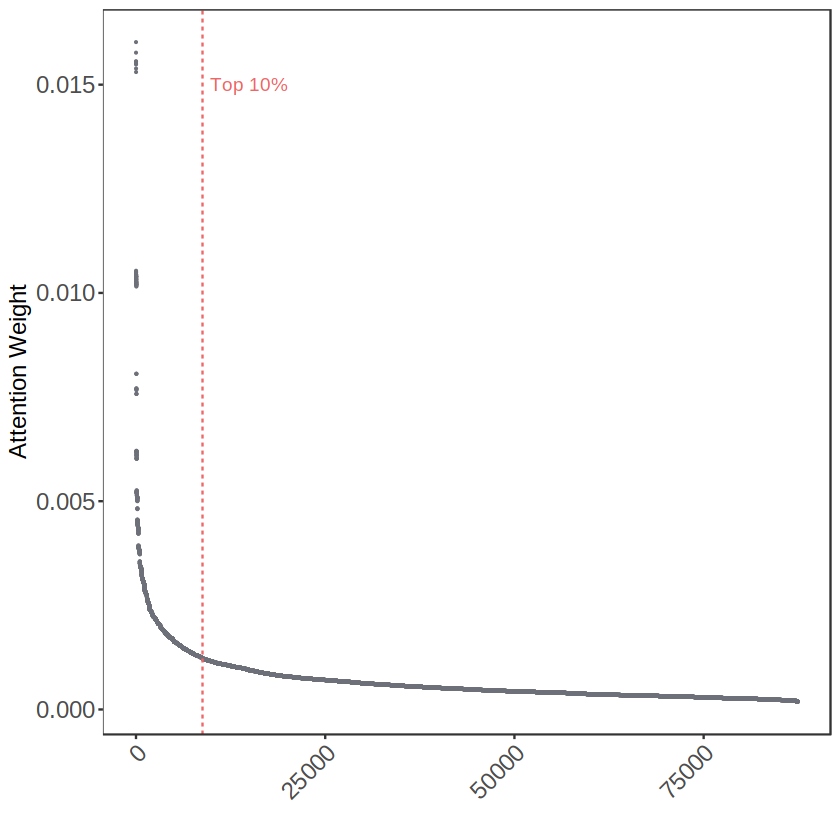

In [13]:
ggplot(attention2, aes(x=pos, y=value)) + geom_point(alpha=1, size=0.1, color="#6e7079") + 
theme_bw() + labs(x="", y="Attention Weight") + 
geom_vline(xintercept=nrow(attention2)*0.1, color="#ee6666", linetype = "dashed") + 
annotate("text", x=nrow(attention2)*0.1+1000, y=0.015, hjust = 0, color="#ee6666", label="Top 10%") + 
theme(axis.text=element_text(size=14), axis.text.x=element_text(angle=45, hjust = 1), axis.title=element_text(size=14)) +
theme(panel.grid = element_blank())

In [14]:
gplink_f <- attention %>% arrange(desc(value)) %>% filter(value > quantile(value, .9))
names(gplink_f) <- c('gene', 'peak', 'weight')

gplink_fre <- as.data.frame(sort(table(gplink_f$gene),decreasing=T))
names(gplink_fre) <- c('gene', 'count')
rownames(gplink_fre) <- gplink_fre$gene

top10_gene <- gplink_fre %>% subset(count>=10) %>% pull(gene) %>% unique %>% as.character 

hw_peak <- gplink_f %>% pull(peak) %>% unique

##### DEG

In [44]:
pbmc.markers <- FindAllMarkers(pbmc, assay='RNA')
pbmc.markers <- pbmc.markers %>% subset(p_val_adj<0.01)
pbmc.markers <- pbmc.markers %>% subset(gene %in% hvg$V1)

In [24]:
pbmc.marker.top <- rbind(pbmc.markers %>% group_by(cluster) %>% top_n(10, avg_log2FC),
                         pbmc.markers %>% group_by(cluster) %>% top_n(10, -avg_log2FC))

In [25]:
gene_df <- data.frame(gene = top10_gene)

In [26]:
gene_df <- merge(gene_df, pbmc.markers, by='gene', all.x=T) ## 

In [27]:
gene_df[is.na(gene_df$p_val), 'avg_log2FC'] = 0
gene_df[is.na(gene_df$p_val), 'p_val_adj'] = 1

In [29]:
gene_df$ind <- 1:nrow(gene_df)

Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”


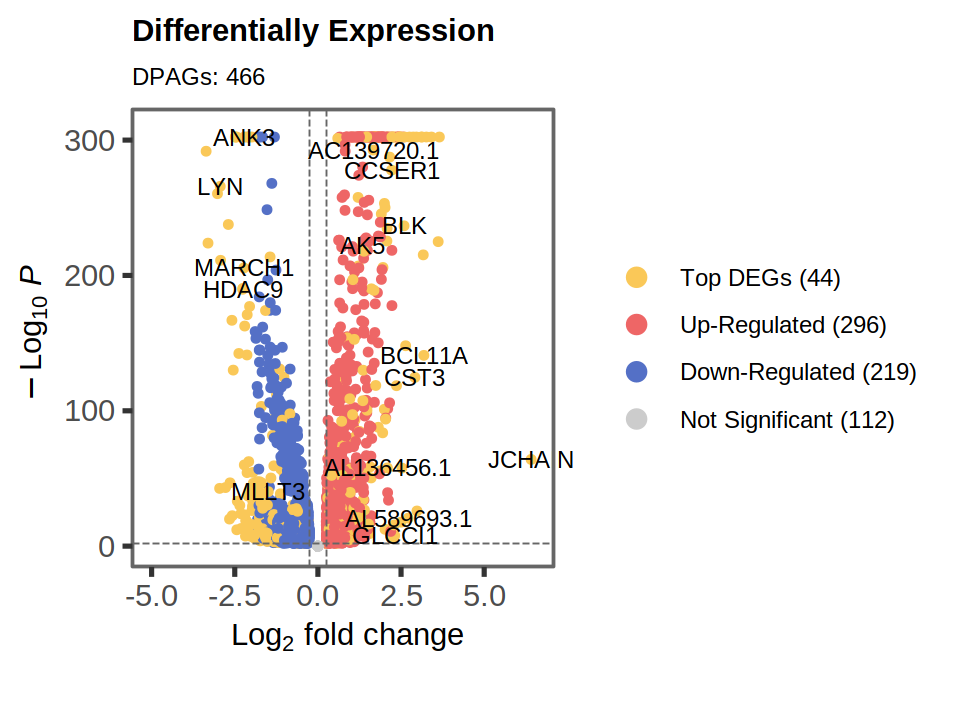

In [31]:
options(repr.plot.width=8, repr.plot.height=6)
source('EnhancedVolcano.R')

top_pos <- gene_df %>% subset(gene %in% intersect(gene_df %>% pull(gene) %>% unique %>% as.character, pbmc.marker.top$gene %>% unique)) %>% group_by(gene) %>% filter(abs(avg_log2FC)==max(abs(avg_log2FC))) %>% pull(ind)
pos <- which(gene_df$gene %in% intersect(gene_df %>% pull(gene) %>% unique %>% as.character, pbmc.marker.top$gene %>% unique))

keyvals <- rep('#fac858', nrow(gene_df))
names(keyvals) <- rep(paste0('Top DEGs (', gene_df[pos,'gene'] %>% unique %>% length, ')'), nrow(gene_df))

# up
pcf <- 1e-2
fccf <- 0.25

down <- which(gene_df$p_val_adj<pcf & gene_df$avg_log2FC<(-fccf))
down <- setdiff(down, pos)
keyvals[down] <- '#5470c6'
names(keyvals)[down] <- paste0('Down-Regulated (', gene_df[down,'gene'] %>% unique %>% length, ')')

up <-  which(gene_df$p_val_adj<pcf & gene_df$avg_log2FC>fccf)
up <- setdiff(up, pos)
keyvals[up] <- '#ee6666'
names(keyvals)[up] <- paste0('Up-Regulated (', gene_df[up,'gene'] %>% unique %>% length, ')')

left <- setdiff(1:nrow(gene_df), union(union(pos, up), down))
keyvals[left] <- '#cccccc'
names(keyvals)[left] <- paste0('Not Significant (', gene_df[left,'gene'] %>% unique %>% length, ')')

colmap = c('#fac858', '#ee6666', '#5470c6', '#cccccc')
nn <- names(keyvals) %>% unique
names(colmap) <- c(nn[nn %>% str_starts("Top")], nn[nn %>% str_starts("Up")], nn[nn %>% str_starts("Down")], nn[nn %>% str_starts("Not")])

EnhancedVolcano(
    gene_df,
    lab = gene_df$gene,
    selectLab = top_pos,
    x = 'avg_log2FC',
    y = 'p_val_adj',
    title = 'Differentially Expression',
    subtitle = paste0('DPAGs: ', length(top10_gene)),
    xlim = c(-5, 6.5),
    pCutoff = pcf,
    FCcutoff = fccf,
    cutoffLineCol = '#666666',
    colAlpha = 1,
    colCustom = keyvals,
    border = 'full',
    legendPosition = 'right',
    caption = '',
    borderColour = '#666666',
    colmap = colmap
)

In [32]:
gene_df[pos,'type'] <- 'Top DEGs'
gene_df[down,'type'] <- 'Down-Regulated'
gene_df[up,'type'] <- 'Up-Regulated'
gene_df[left,'type'] <- 'Not Significant'

In [33]:
diff_genes <- gene_df[union(union(pos, up), down),'gene'] %>% unique
top_deg <- gene_df[pos, 'gene'] %>% unique

##### enrichment - msigdb

In [36]:
m_t2g <- msigdbr(species = "Homo sapiens", category = "C5", subcategory='GO:BP') %>%
    distinct(gs_name, gene_symbol) %>% select(gs_name, gene_symbol) %>% as.data.frame()  ## entrez_gene, , gs_description

In [37]:
gene <- diff_genes

In [38]:
em <- enricher(gene, TERM2GENE=m_t2g)

In [39]:
enrich_tmp <- em@result
enrich_tmp$fre <- sapply(enrich_tmp$GeneRatio, function(x){eval(parse(text=x))})
enrich_tmp$logp <- -log10(enrich_tmp$p.adjust)
enrich_tmp$bp <- tolower(str_replace_all(str_replace(enrich_tmp$ID, 'GOBP_', ''), "_", " "))
go_subset <- enrich_tmp[order(enrich_tmp$fre,enrich_tmp$p.adjust,decreasing=T),]

In [40]:
go_subset <- go_subset %>% group_by(geneID) %>% filter(pvalue==min(pvalue))

In [41]:
go_subset <- go_subset[1:10,]

In [42]:
go_subset$bp <- factor(go_subset$bp, levels=rev(go_subset$bp))

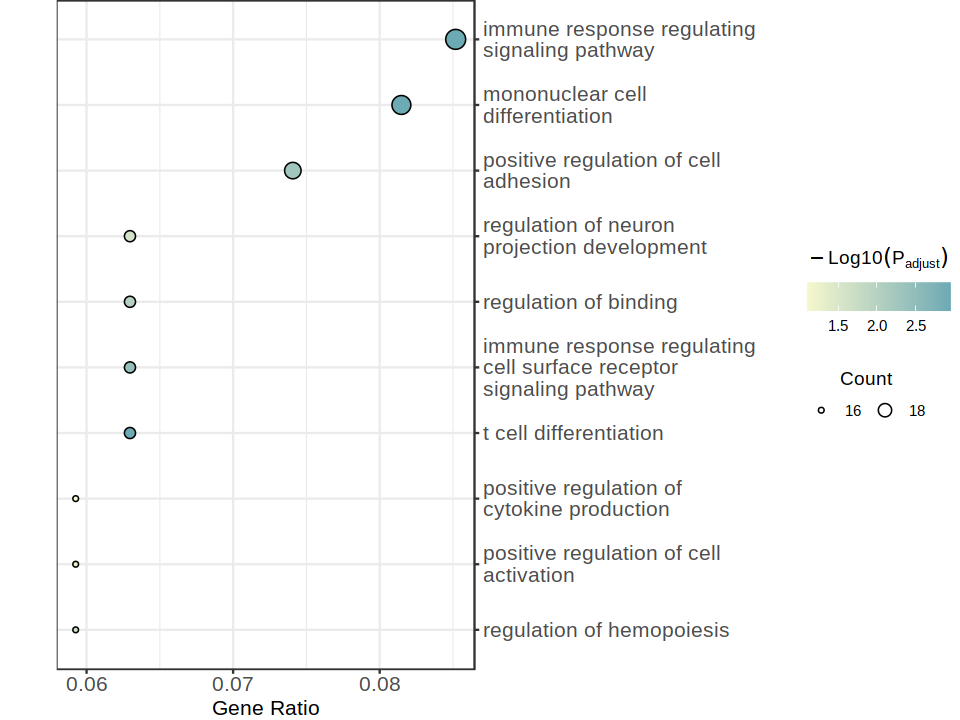

In [45]:
options(repr.plot.width=8, repr.plot.height=6)
go_subset %>% ggplot(aes(x=fre,y=bp)) +
    geom_point(aes(size=Count,fill=logp),shape=21) + theme_bw() + xlab('Gene Ratio') + ylab('') +
    scale_y_discrete(position = "right",labels = function(x){str_wrap(x, width = 30)}) + theme(legend.direction="horizontal") + 
    scale_fill_gradient(low="#F6F8CD", high ="#6CAAB4",name = expression(-Log10(P[adjust]))) + scale_size(range = c(1,5), breaks = c(14,16,18)) +
    guides(size = guide_legend(title.position="top", title.hjust = 0.5),fill = guide_colourbar(title.position="top", title.hjust = 0.5)) +
    theme(axis.text=element_text(size=12),axis.title=element_text(size=12), plot.margin = margin(0,0,0,1.2, "cm"))

##### pheatmap

###### RNA

In [51]:
get_normalized_data <- function(gene){
    df <- c()
    for(ct in use_ct){
        cells <- pbmc@meta.data %>% subset(celltype == ct) %>% rownames
        tmp <- pbmc$RNA[gene, cells]
        tmp <- rowMeans(tmp)
        df <- cbind(df, tmp)
    }

    colnames(df) <- use_ct

    center <- sweep(df, 1, apply(df, 1, min),'-')
    R <- apply(df, 1, max) - apply(df, 1, min)
    df <- sweep(center, 1, R, "/")
    return(df)
}

In [52]:
gp_f <- gplink_f %>% subset(gene %in% top10_gene) %>% select(gene, peak, weight)

In [53]:
gene <- as.character(gp_f$gene)
df_rna <- get_normalized_data(gene)

###### peak

In [56]:
peak <- gp_f %>% pull(peak)

In [57]:
df_peak <- c()
for(ct in use_ct){
    cells <- pbmc@meta.data %>% subset(celltype == ct) %>% rownames
    tmp <- pbmc$ATAC[peak, cells]
    tmp <- rowMeans(tmp)
    df_peak <- cbind(df_peak, tmp)
}

In [58]:
colnames(df_peak) <- use_ct

In [59]:
center <- sweep(df_peak, 1, apply(df_peak, 1, min),'-')
R <- apply(df_peak, 1, max) - apply(df_peak, 1, min)
df_peak <- sweep(center, 1, R, "/")

###### combine

In [60]:
od <- hclust(dist(df_rna * df_peak),method='ward.D2')$order

In [61]:
col_pos <- c('MAIT','NK','CD8 TEM_1','CD8 TEM_2','gdT',
             'CD4 Naive','CD8 Naive','Treg','CD4 TCM','CD4 TEM',
             'cDC','CD14 Mono','CD16 Mono',
             'Plasma','Memory B','Naive B','Intermediate B','HSPC','pDC')
cut_col_ind <- c(10,17)

In [62]:
row_tmp <- cutree(hclust(dist(df_rna * df_peak),method='ward.D2'), 7)[od]
cut_row_ind <- c()
for(i in 1:7){
    cut_row_ind <- c(cut_row_ind, which(row_tmp == i)[1])
}
cut_row_ind <- as.numeric(sort(cut_row_ind))[-1]

In [64]:
top_deg_anno <- data.frame(gene = rownames(df_rna[od,]))
top_deg_anno[top_deg_anno$gene %in% top_deg, 'DEG'] <- 'True'
top_deg_anno$DEG[is.na(top_deg_anno$DEG)] <- 'False'

In [65]:
ha_pos <- c(73, 90, 171, 373, 550,
            633, 648, 783, 1331, 1891,
            1903, 2107, 2180, 2718,
            2727, 3556, 3570, 3836, 3840,
            4136, 4646, 5765, 5973)

ha_label <- c('TOX', 'FGFBP2', 'ZBTB16', 'LEF1', 'NELL2',
              'THEMIS', 'TXK', 'RORA', 'CAMK4', 'CST3',
              'HDAC9', 'LYN', 'CCSER1', 'ZEB2',
              'ANXA1', 'JCHAIN', 'SEC11C', 'BANK1', 'RALGPS2',
              'EBF1', 'CDK6', 'ZFAT', 'BCL11A')

In [66]:
ha = rowAnnotation(foo = anno_mark(at = ha_pos, labels_gp = gpar(fontsize = 10),
    labels = ha_label))

In [67]:
p1 <- pheatmap(df_rna[od, col_pos], color = colorRampPalette(c("#464646", "#fac858"))(100),
    show_rownames = FALSE, clustering_method='ward.D2', use_raster=F,
    cluster_rows = F, gaps_row = cut_row_ind, cluster_cols = F,
    legend = FALSE,
    cellwidth = unit(7, 'mm'), column_title = "RNA",
    right_annotation = ha,
)

In [68]:
p2 <- rowAnnotation(weight = anno_lines(gp_f$weight[od], gp = gpar(col='#5470c6', border="#6e7079"), smooth=T, add_points=F, width = unit(1, "cm")))

In [69]:
p3 <- rowAnnotation(Top_DEGs=top_deg_anno$DEG, col=list(Top_DEGs=c('False'='white','True'='#CC3636')), show_legend=F)

In [70]:
p4 <- pheatmap(df_peak[od, col_pos], color = colorRampPalette(c("#464646", "#fac858"))(100),
    show_rownames = FALSE, clustering_method='ward.D', use_raster=F, name = "Normalized Value",
    cluster_rows = F, gaps_row = cut_row_ind, cluster_cols = F,
    cellwidth = unit(4, 'mm'), column_title = "ATAC"
)

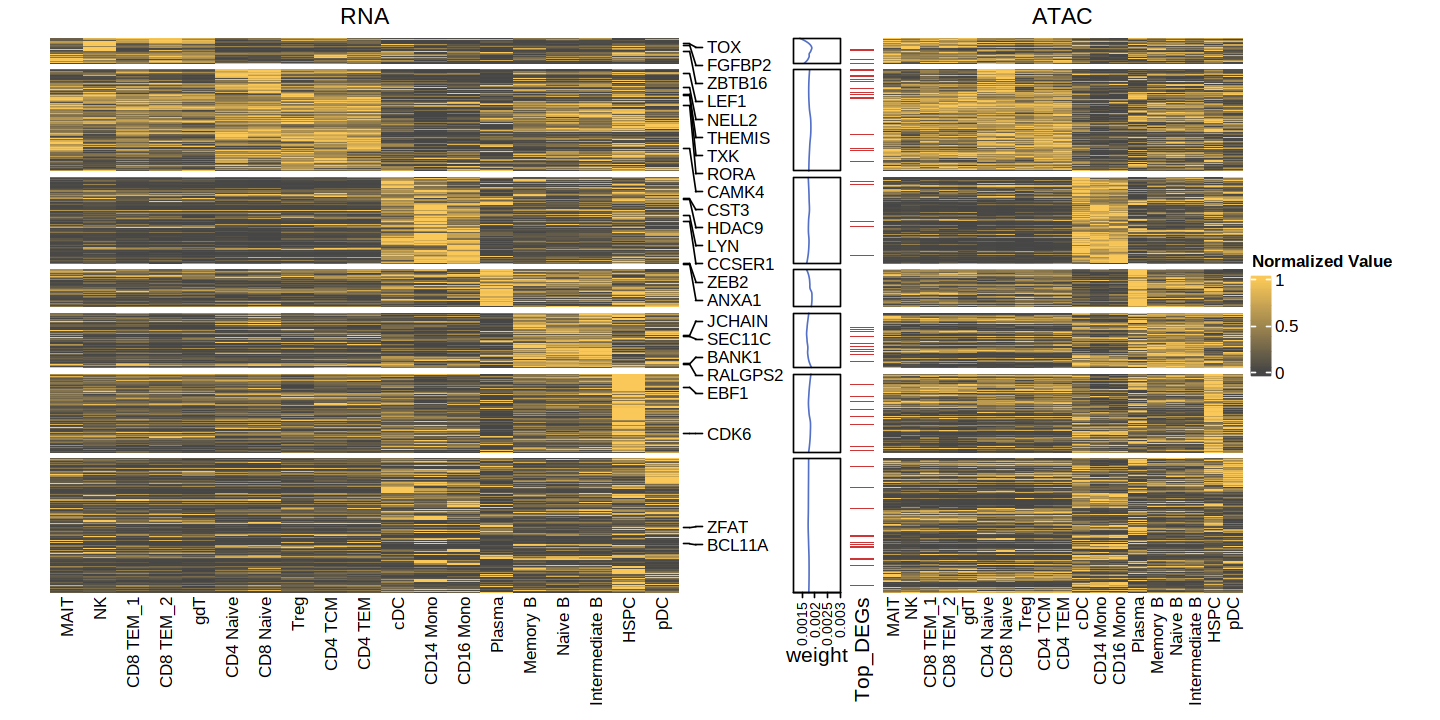

In [71]:
options(repr.plot.width=12, repr.plot.height=6)
p1 + p2 + p3 + p4

###### partial top gene exp

In [102]:
df_p <- df_rna[!duplicated(df_rna),]
tmp_g <- rownames(df_p)
df_p <- as.data.frame(df_p)

In [103]:
df_p$gene <- tmp_g

In [104]:
df_p <- melt(df_p, id='gene')

In [105]:
names(df_p) <- c('gene', 'celltype', 'exp')

In [106]:
df_p <- df_p %>% subset(gene %in% ha_label)

In [107]:
df_p$gene <- factor(df_p$gene, levels=ha_label)

In [108]:
df_p$celltype <- factor(df_p$celltype, levels=rev(col_pos))

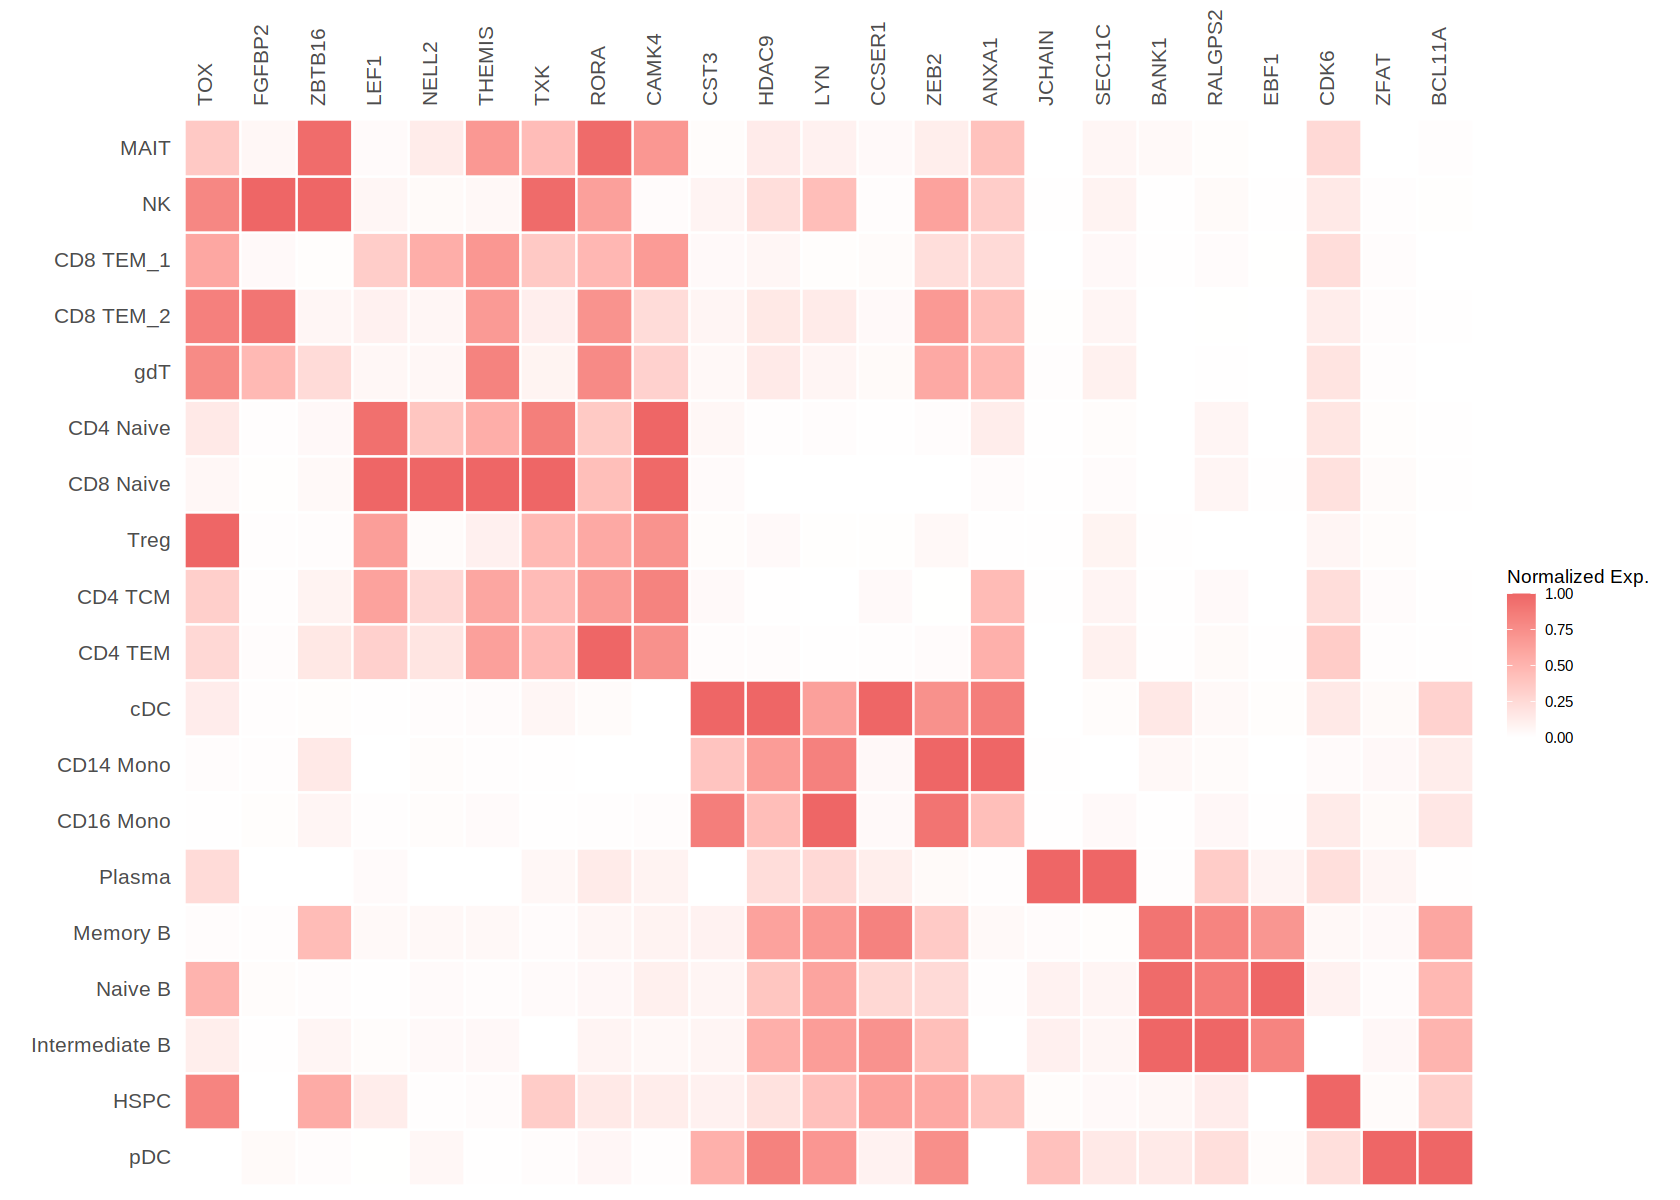

In [109]:
options(repr.plot.width=8, repr.plot.height=4)
ggplot(df_p, aes(x=gene, y=celltype, fill=exp)) + geom_tile(colour= "white", size = 0.5) + coord_equal() + 
    scale_fill_gradient(name='Normalized Exp.', low="white", high="#ee6666") + theme_bw() + labs(colour='', size='Normalized Expression') + scale_x_discrete(position="top") + scale_size(range = c(1,3), breaks = c(0, 0.5, 1)) + 
    theme(legend.position="right", panel.border=element_blank(), panel.grid=element_blank(), axis.text.x=element_text(angle=90, hjust=0, size=12), axis.text.y=element_text(size=12), axis.title = element_blank(), axis.ticks = element_blank())